In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_cox import *
from DZFW_cox import *
from IZFW_cox import *

## Load data

In [3]:
clinical = pd.read_table('../Data/SurvivalTimes.txt', index_col=0, sep=';')
clinical = clinical.set_index(clinical["IDs"], drop=True).iloc[:,:-1]
clinical["death_event"].value_counts()

0    375
1    162
Name: death_event, dtype: int64

In [4]:
data = pd.read_table("../Data/mydata.txt", sep = ";")
data = data.T

In [5]:
df = data.merge(clinical, left_index= True, right_index = True)
df = df.sort_values(by = "new_death")
df.head()

,?|10431,?|553137,?|57714,?|653553,?|8225,A2M|2,A4GALT|53947,AAAS|8086,AACS|65985,AAGAB|79719,...,ZSWIM7|125150,ZW10|9183,ZXDB|158586,ZXDC|79364,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,new_death,death_event
TCGA-A3-A8OX,864.8329,123.6901,762.7553,259.3501,527.3452,32553.2802,972.8954,525.3502,734.8253,741.1428,...,470.8900,328.5101,289.2751,967.5754,990.5179,4045.8617,1415.1206,592.1828,0,0
TCGA-A3-A8OU,642.0154,431.5319,624.5429,399.0248,788.7038,31333.4945,1786.6721,702.1536,526.2089,503.0475,...,419.2483,250.7111,383.1776,1112.9622,899.2280,4225.9244,1418.1227,449.8171,0,0
TCGA-BP-4337,934.0463,772.7273,466.1319,596.2567,699.6435,32191.5642,2510.2496,938.0570,881.4617,651.9608,...,267.3975,228.6096,189.8396,1154.1889,616.7558,5067.7362,1319.0731,471.0339,2,1
TCGA-A3-A8CQ,477.9031,283.6534,722.9503,337.7019,779.4372,31045.7665,1935.5887,615.6660,712.7908,408.4121,...,250.2895,289.7491,376.3080,1091.9435,967.9976,3791.5270,1752.7177,611.6022,3,0
TCGA-A3-A6NN,310.8729,556.6616,915.3905,234.3032,463.6294,40603.1432,2385.1455,638.2083,343.4150,494.6401,...,282.2358,351.8377,465.1608,907.7335,1130.1685,2765.3139,2091.5008,774.1194,3,0


In [6]:
X, y, time = df.iloc[:,:-2], df.iloc[:,-1].values, df.iloc[:,-2].values
X = np.array(X.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0))
print(f"X shape: {X.shape}\ny shape: {y.shape}\ntime shape: {time.shape}")

X shape: (533, 9375)
y shape: (533,)
time shape: (533,)


In [7]:
n, d = X.shape

In [8]:
# initialize parameters for the algorithms
# stating point 
np.random.seed(7)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1) *10

# Lipschitz constant 
L = 0.1

In [9]:
np.linalg.norm(w0, 1)

8.899985191618605

In [10]:
#np.min([np.min(f_i), np.min(f_stoch200), np.min(f_d)])
#np.argmin([np.min(f_i), np.min(f_stoch200), np.min(f_d)])

In [11]:
f_star = 1.426645363070986

In [12]:
@njit
def F(w):
    output = 0
    for i in range(X.shape[0]):
        if y[i] == 1:
            sum_jR = np.sum(np.exp((X @ w)[i:]))
            output += y[i]*(-X[i,:] @ w + np.log(sum_jR))
    return 1/X.shape[0] * output

## Deterministic Gradient Free Frank Wolfe

In [13]:
%%time
#fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=100)
#print(F(w0), F(w))
#print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15.7 µs


In [14]:
'''
L = 50
OUTPUT:

F(w_pred) = 1.426645363070986

F(w) = 1.427460335672531

w = [2.82792244e-08 2.89031489e-07 1.62470855e-07 ... 9.93704486e-08
 4.01305222e-09 1.90532377e-07]

average w = [1.42810083e-06 1.45960902e-05 8.20477818e-06 ... 5.01820765e-06
 2.02659137e-07 9.62188506e-06]

T = 100
2.1905202447317844 1.427460335672531
'''

'\nL = 50\nOUTPUT:\n\nF(w_pred) = 1.426645363070986\n\nF(w) = 1.427460335672531\n\nw = [2.82792244e-08 2.89031489e-07 1.62470855e-07 ... 9.93704486e-08\n 4.01305222e-09 1.90532377e-07]\n\naverage w = [1.42810083e-06 1.45960902e-05 8.20477818e-06 ... 5.01820765e-06\n 2.02659137e-07 9.62188506e-06]\n\nT = 100\n2.1905202447317844 1.427460335672531\n'

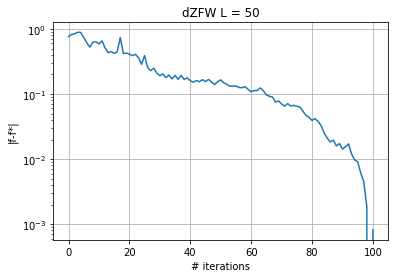

In [15]:
f_d = np.load('../Data/results/function_DZFW_cox_50.npy')
plt.plot(f_d - f_star)
plt.yscale("log")
plt.title("dZFW L = 50")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Stochastic Gradient Free Frank Wolfe

In [16]:
%%time
#fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=10, T=20, eps=1e-5)

#print(F(w0), F(w))
#print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 13.4 µs


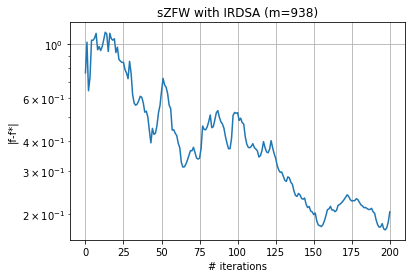

In [17]:
f_stoch200 = np.load('../Data/results/function_SZFW_IRDSA_cox_200.npy')
plt.plot(f_stoch200 - f_star)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=938)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates

In [18]:
%%time

# setting parameters
B=1   
D=10000

#fpred, f, w, mean, t, loss, f_value = IZFW(F, d, w0, L, B = 1, r = 10, T = 100, eps = 1e-5)
#print(F(w0), F(w))
#print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

"""
OUTPUT:

F(w_pred) = 1.621374158024038

F(w) = 1.6251153827213625

w = [6.69117374e-09 9.72977140e-09 7.45566032e-11 ... 7.99886892e-09
 1.09944720e-08 2.63635676e-09]

average w = [3.37904274e-07 4.91353456e-07 3.76510846e-09 ... 4.03942880e-07
 5.55220837e-07 1.33136016e-07]

T = 100
1.6905172271257587 1.6251153827213625
"""

CPU times: user 51 µs, sys: 2 µs, total: 53 µs
Wall time: 65.8 µs


'\nOUTPUT:\n\nF(w_pred) = 1.621374158024038\n\nF(w) = 1.6251153827213625\n\nw = [6.69117374e-09 9.72977140e-09 7.45566032e-11 ... 7.99886892e-09\n 1.09944720e-08 2.63635676e-09]\n\naverage w = [3.37904274e-07 4.91353456e-07 3.76510846e-09 ... 4.03942880e-07\n 5.55220837e-07 1.33136016e-07]\n\nT = 100\n1.6905172271257587 1.6251153827213625\n'

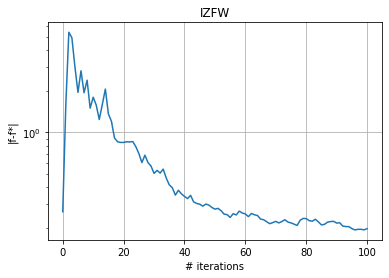

In [19]:
f_i = np.load('../Data/results/function_IZFW_cox.npy')
plt.plot(f_i - f_star)
plt.yscale("log")
plt.title("IZFW")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

### Time estimation for IZFW (while not counted)

In [20]:
%%time
F(w0)

CPU times: user 3.3 s, sys: 59.3 ms, total: 3.36 s
Wall time: 2.64 s


2.1905202447317853

In [21]:
m = lambda t: t * (t+1) / D * (d+3)
np.sum([m(t) for t in range(1,101)])

322040.52

In [22]:
secs = 661 * 322040.52 / 1000
hours = secs / 60**2

In [23]:
(3.50 - hours/24)/(hours/24)

0.4205934506478233

## Results comparison

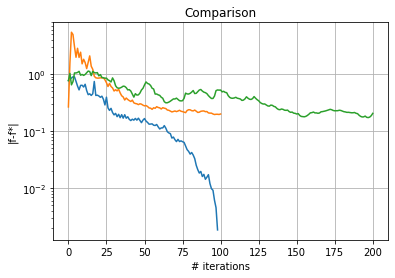

In [24]:
plt.plot((f_d - f_star)[:np.argmin(f_d)])
plt.plot(f_i - f_star)
plt.plot(f_stoch200 - f_star)
plt.yscale("log")
plt.title("Comparison")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

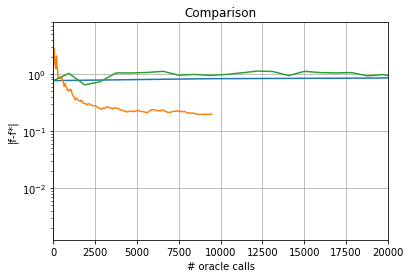

In [25]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, 100*d, d)[:np.argmin(f_d)], (f_d - f_star)[:np.argmin(f_d)])
plt.plot([m(t) for t in range(101)], f_i - f_star)
plt.plot(range(0, 200*938+1, 938),f_stoch200 - f_star)
plt.yscale("log")
plt.title("Comparison")
plt.xlabel("# oracle calls")
plt.ylabel("|f-f*|")
plt.xlim((0,20000))
plt.grid()